In [2]:
import os
from pathlib import Path 
import numpy as np
import nibabel as nib
import nibabel.processing
import time
import sys
from scipy import sparse
from matplotlib import pyplot as plt
from nilearn import plotting, image
from scipy import ndimage
import argparse 
import tempfile
import subprocess
import pickle
import shutil
from itertools import repeat
from scipy.sparse import csr_matrix

In [3]:
def flatParcellationToTransform(Pflat, isubj=None, out_type="csr", max_sequential_roi_value=None):
    if sparse.issparse(Pflat):
        Pdata=Pflat[isubj,:].toarray().flatten()
    elif isubj is None:
        Pdata=Pflat.flatten()
    elif len(Pdata.shape)==2:
        Pdata=Pflat[isubj,:].flatten()
            
    numvoxels=np.prod(Pdata.shape)
    pmaskidx=np.where(Pdata!=0)[0]
    uroi, uidx=np.unique(Pdata[Pdata!=0],return_inverse=True)
    numroi=len(uroi)
    
    if max_sequential_roi_value is not None:
        #this would create an entry at the actual ROI values, rather than just going through the sequential PRESENT value
        #eg: for cc400 it would be a 7M x 400 array instead of 7M x 392
        #   but for an arbitrary/custom input, where they left freesurfer values, this could make it in the thousands!
        uidx=(uroi[uidx]-1).astype(np.int64)
        numroi=max_sequential_roi_value.astype(np.int64)
    
    if out_type == "csr":
        return sparse.csr_matrix((np.ones(pmaskidx.size),(pmaskidx,uidx)),shape=(numvoxels,numroi),dtype=np.float32)
    elif out_type == "csc":
        return sparse.csc_matrix((np.ones(pmaskidx.size),(pmaskidx,uidx)),shape=(numvoxels,numroi),dtype=np.float32)


In [5]:
filename = "/mnt/h/srs-9/chaco/sub1001-20170215/thomas_thalamus.nii.gz"
Pimg=nib.load(filename)
Pdata=Pimg.get_fdata()

max_seq_roi_val=None

Psparse = flatParcellationToTransform(Pdata.flatten(), None, out_type="csr", max_sequential_roi_value=max_seq_roi_val)
numroi = Psparse.shape[1]

In [6]:
endpointAsum = sparse.load_npz("/mnt/h/chaco_batches/localnemo/nemo_Asum_endpoints.npz")
endpointAsum.shape

(420, 7221032)

In [7]:
Psparse.shape

(7221032, 10)

In [27]:
nemo_dir = Path("/mnt/h/srs-9/chaco/sub1001-20170215/lesion_mask_mni_nemo_output")
filename = "lesion_mask_mni_nemo_output_ifod2act_chacovol_res1mm_mean.nii.gz"
chaco_file = nemo_dir / filename
chacovol_mean = nib.load(chaco_file).get_fdata()

filename = "lesion_mask_mni_nemo_output_ifod2act_chacovol_res1mm_stdev.nii.gz"
chaco_file = nemo_dir / filename
chacovol_std = nib.load(chaco_file).get_fdata()

In [28]:
mean_chacos = []
for idx in range(1, 11):
    chaco_means = chacovol_mean[Pdata == idx]
    chaco_stds = chacovol_std[Pdata == idx]
    weighted_chaco = np.sum(chaco_means / chaco_stds**2) / np.sum(1 / chaco_stds**2)
    mean_chacos.append(weighted_chaco)

/tmp/ipykernel_678340/1314692424.py:5: RuntimeWarning: invalid value encountered in divide
  weighted_chaco = np.sum(chaco_means / chaco_stds**2) / np.sum(1 / chaco_stds**2)
/tmp/ipykernel_678340/1314692424.py:5: RuntimeWarning: divide by zero encountered in divide
  weighted_chaco = np.sum(chaco_means / chaco_stds**2) / np.sum(1 / chaco_stds**2)


In [29]:
mean_chacos

[np.float64(0.0508688484229237),
 np.float64(0.06699998320644726),
 np.float64(0.03682589535822039),
 np.float64(0.04794308856370973),
 np.float64(0.03186602618459437),
 np.float64(0.04895349102470388),
 np.float64(nan),
 np.float64(0.0396178540436299),
 np.float64(0.057080115471427884),
 np.float64(0.06847450083444867)]

0.02490574368130183


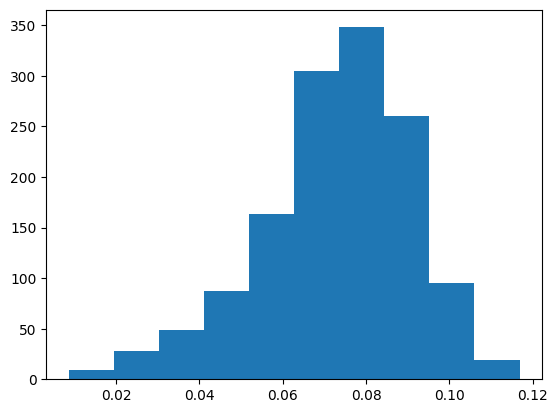

In [23]:
mean_chacos = []
for idx in range(1, 11):
    chaco_vals = data[Pdata == idx]
    mean_chacos.append(chaco_vals.mean())
plt.hist(chaco_vals)
print(chaco_vals[len(chaco_vals)//2])

In [25]:
mean_chacos

[np.float64(0.056728043221417314),
 np.float64(0.07048230594109417),
 np.float64(0.04970836273381652),
 np.float64(0.05833122023618951),
 np.float64(0.03717169936724419),
 np.float64(0.06497520823226782),
 np.float64(0.009711612824216181),
 np.float64(0.04217460730063749),
 np.float64(0.05985130600734626),
 np.float64(0.07280325995909334)]

In [24]:
nemo_dir2 = Path("/mnt/h/srs-9/chaco/sub1001-20170215/lesion_mask_mni_nemo_output_sdstreamANDifod2act_20260221_052753046")
volumefile = nemo_dir2 / "lesion_mask_mni_nemo_output_ifod2act_chacovol_thomas_mean.pkl"
chaco_roi = pickle.load(open(volumefile,"rb"))[0]
print(chaco_roi)

[0.04087242 0.03003209 0.01097609 0.01991428 0.02791258 0.05090195
 0.02939486 0.03634316 0.02219668 0.03861215]


In [26]:
from scipy.stats import pearsonr

pearsonr(mean_chacos, chaco_roi)

PearsonRResult(statistic=np.float64(0.21244884900724653), pvalue=np.float64(0.5556816633443631))

In [14]:
nemo_dir = Path("/mnt/h/srs-9/chaco/lesion_mask_mni_nemo_output_allsubs")
filepath = nemo_dir / "lesion_mask_mni_nemo_output_ifod2act_chacovol_res1mm_allref.pkl"
chacovol_allref = pickle.load(open(filepath,"rb"))
filepath = nemo_dir / "lesion_mask_mni_nemo_output_ifod2act_chacovol_res1mm_allref_denom.pkl"
chacovol_allref_denom = pickle.load(open(filepath,"rb"))

filepath = nemo_dir / "lesion_mask_mni_nemo_output_ifod2act_chacovol_res1mm_mean.nii.gz"
chacovol_mean = nib.load(filepath).get_fdata()

/tmp/ipykernel_696003/2967817850.py:3: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  chacovol_allref = pickle.load(open(filepath,"rb"))
/tmp/ipykernel_696003/2967817850.py:5: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  chacovol_allref_denom = pickle.load(open(filepath,"rb"))


In [18]:
roi_chaco_allsubj_denom = chacovol_allref_denom @ Psparse
roi_chaco_allsubj_denom.data=1/roi_chaco_allsubj_denom.data.astype(np.float32)

roi_chaco_allsubj = (chacovol_allref.multiply(chacovol_allref_denom) @ Psparse).multiply(roi_chaco_allsubj_denom)

In [23]:
chacomean=np.array(np.mean(roi_chaco_allsubj,axis=0))
chacomean

array([[0.06842905, 0.07812529, 0.0422927 , 0.05754404, 0.03586639,
        0.06835434, 0.04127354, 0.04181038, 0.0605131 , 0.08536606]],
      dtype=float32)

In [6]:
chacovol_mean_flat = chacovol_mean.flatten()
chacovol_allref_mean = np.array(chacovol_allref.mean(axis=0))

In [7]:
chacovol_allref_vol = chacovol_allref_mean.reshape(chacovol_mean.shape)

In [8]:
chacovol_allref_vol[Pdata == 2].mean()

np.float32(0.07048253)

In [9]:
chacovol_mean[Pdata==2].mean()

np.float64(0.07048230594109417)

In [13]:
Pflat = Pdata.flatten()
check = chacovol_allref[:, Pflat==2].mean(axis=1)
check.mean()

np.float32(0.07048254)

In [27]:
path = nemo_dir / "test.npz"
check = sparse.load_npz(path)
check.data

array([0.05598677, 0.03385053, 0.03743149, ..., 0.10845004, 0.1201487 ,
       0.09894329], shape=(4195,))